## 1. 소개
LendingClub.com에서 공개적으로 이용할 수 있는 데이터. 렌딩클럽은 돈이 필요한 사람(대출자)과 돈이 있는 사람(투자자)을 연결한다. 투자자로서 당신에게 갚을 확률이 높다는 프로파일을 보여준 사람들에게 투자하길 바랍니다.

우리는 2007년부터 2010년까지의 대출 데이터를 사용하여 대출자가 대출금을 전액 상환했는지 여부를 분류하고 예측하려고 합니다.

소비자의 지불 여부를 예측하는 모델은 기업이 자원을 더 잘 분배하는 데 도움이 될 수 있다. 예를 들어, 기업이 차입자 프로필을 가지고 있는 경우 각 사례에 최고의 채무 회수자를 할당할 수 있습니다. 그들은 또한 대출자가 빚을 갚는 것을 도울 수 있는 지불 전략을 마련할 수 있다.

이 커널에서는 차입자의 채무 지급 여부를 결정하는 관련 요소를 결정한 다음 차입자 프로필을 만들고 최종적으로 결론을 내리고 비즈니스를 개선하기 위한 권고사항을 제시하려고 합니다.

### 1.1. 목표

- 차입자의 지급 여부에 영향을 미치는 관련 요인을 찾는다.
- 차입자의 지불 여부를 예측하는 모델을 구축합니다.
- 돈을 지불하거나 지불하지 않는 대출자의 소비자 프로필을 만드세요.
- 비즈니스 운영을 개선하기 위한 결론 및 권장 사항을 제시합니다.

### 1.2. 특징
- credit.policy: 고객이 LendingClub.com의 신용 계약 기준을 충족하는 경우 1이고, 그렇지 않은 경우 0입니다.
- 목적: 대출의 목적("신용 카드", "부채 통합", "교육", "주요 구매", "소기업" 및 "전체_기타" 값을 취함)
- 비율: 대출의 이자율(11%의 이자율은 0.11로 저장됨). LendingClub.com이 더 위험하다고 판단한 대출자에게는 더 높은 금리가 할당된다.
- 할부: 대출이 자금으로 지원될 경우 차입자가 갚아야 할 월 할부.
- log.vmdk.inc: 자가 보고한 차입자의 연간소득의 자연로그.
- dti: 차입자의 총부채비율(채무액을 연소득으로 나눈 값) 차입자의 FICO 신용점수.
- days.with.cr.line: 대출자의 신용 한도 일수입니다.
- revol.bal: 대출자의 회전 잔액(신용카드 청구 주기가 끝날 때 미지급된 금액)
- revol.1987: 차입자의 회전선 이용률(사용 가능한 총 신용에 비해 사용한 신용선 금액)
- Q.last.6ms: 지난 6개월 동안 채권자의 문의 건수.
- delinq.2yrs: 지난 2년간 대출자가 지급 기한을 30일 이상 경과한 횟수.
- pub.rec: 차용자의 공개 기록(파산 신청, 세금 공제 또는 판결) 수

## 2. Packages, data loading and cleaning
### 2.1. Packages

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
sns.set_style('whitegrid')

#preprocessing
from sklearn.feature_selection import RFE # 재귀적 기능 제거(중요하지 않은 기능 제거)
#그 이후 선택하려는 기능의 수에 도달할 때까지, 제거된 집합에서 재귀적으로 반복

#M1 model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #DecisionTree를 dot형식으로 내보냄
from sklearn.metrics import plot_confusion_matrix

# over-sampling
from imblearn.over_sampling import RandomOverSampler #무작위 오버샘플링 수행
#무작위로 샘플을 대체하여 선택하여 소수 클래스를 과도하게 샘플링

# Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

np.warnings.filterwarnings('ignore')

### 2.2 Data loading

In [4]:
loan=pd.read_csv('loan_data.csv')
display(loan)
display(loan.describe())

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


### 2.3 Data Cleaning

이 단계에서는 중복 항목을 제거하고 Nulls 값을 검사하여 해당 값도 분리할 수 있는지 확인합니다. 의심스러운 데이터가 나타날 수 있는 경우 설명 분석까지 클리닝 프로세스가 저절로 확장될 수 있습니다.

또한 데이터 유형도 살펴보고 불일치할 경우 수정할 예정입니다.

In [6]:
display(loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


None

bool도 bool로 해석될 수 있기 때문에, 데이터 유형을 그대로 둘 수 있습니다. 그러나 설명 섹션의 알고리즘을 사용하여 "credit policy" 와 "not.fully.paid"를 변환할 것입니다."전액.유급"을 지불하고 부울린에게요. 나머지 기능은 모두 순서대로 되어 있습니다.

In [9]:
loan['credit.policy']=loan['credit.policy'].astype('bool')
loan['not.fully.paid']=loan['not.fully.paid'].astype('bool')
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   bool   
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   bool   
dtypes: bool(2), float64(6), int64(5), object(1)
memory usage: 916.8+ KB
None


### Duplicates

In [10]:
loan.drop_duplicates(inplace=True)

### Nulls
Null을 삭제하기 전에 먼저 열 지도를 사용하여 분포 방식을 확인합니다.

<AxesSubplot:>

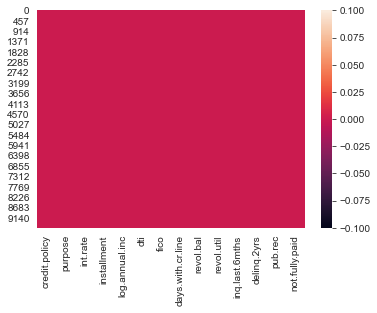

In [11]:
sns.heatmap(loan.isnull())

히트맵을 통해 본 결과, null값이 존재하지 않아 그대로 이어가도 됨

## 3. Descriptive analysis

섹션 2.3을 통해 대부분의 기능이 숫자이며, 범주형 변수와 부울이 하나만 있고, 그 중 하나는 목표 변수인 것입니다. 이렇게 하면 숫자 값에 해당하는 히스토그램만 그래프로 표시하면 되므로 설명 분석이 매우 쉬워집니다. 범주형 피쳐의 막대 그림은 부울의 또 다른 막대 그림입니다.

### 3.1 Categories

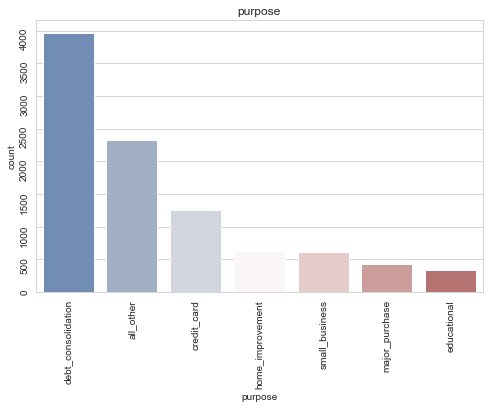

,count,%
debt_consolidation,3957,41.31
all_other,2331,24.34
credit_card,1262,13.18
home_improvement,629,6.57
small_business,619,6.46
major_purchase,437,4.56
educational,343,3.58


In [13]:
fig,ax=plt.subplots(figsize=(8,5))

cat=loan.select_dtypes('object').columns

order=list(loan[cat[0]].value_counts().keys())
sns.countplot(cat[0],data=loan,palette='vlag',order=order)
ax.tick_params(labelrotation=90) # 레이블 90도 회전
ax.set_title(cat[0])

plt.show()

table=pd.DataFrame(loan[cat[0]].value_counts())
table.rename(columns={'purpose':'count'},inplace=True)
table['%']=np.round((table['count']/table['count'].sum()) * 100,2)
table

서술적 분석을 통해 우리는 대부분의 대출자들이 부채 통합(41.31%)을 위한 것임을 알 수 있다. 최소한의 카테고리는 교육적입니다. 결론을 내리기엔 너무 이르지만, 내 직감은 가장 많은 대출자를 가진 카테고리도 가장 큰 비중을 차지한다는 것을 말해준다. 가장 적은 돈을 가진 학생이 맨 아래에 있는 교육 분야이기 때문이다. 하지만 우리가 더 분석할 분석 부분이 나올 때까지 기다리겠습니다.

### 3.2 Numbers

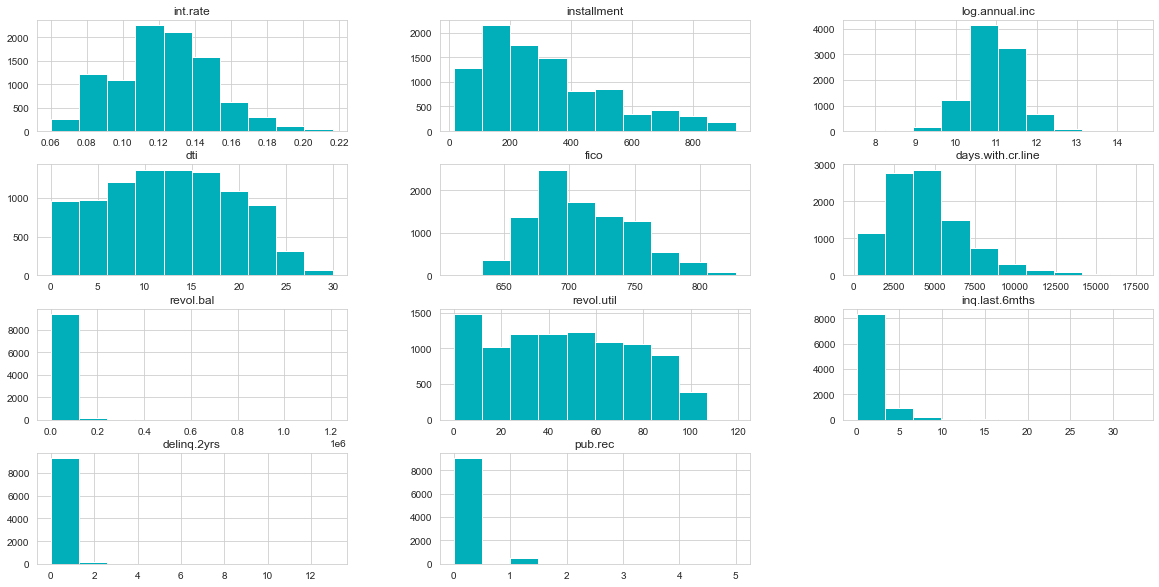

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122
std,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126
min,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000
50%,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000
75%,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000
max,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000


In [18]:
numbers=loan.select_dtypes(['int64','float64']).columns
loan[numbers].hist(figsize=(20,10),edgecolor='white',color='#00afb9')
plt.show()

loan[numbers].describe()

우리는 대부분의 히스토그램이 정규 분포를 따른다는 것을 알 수 있습니다. revol.bal은 기술 통계에서 매우 극단적인 값을 갖는다는 것을 알 수 있습니다. 이 값은 다음과 같은 특이치 또는 적용 로그 공식을 제거하여 수정할 수 있습니다.

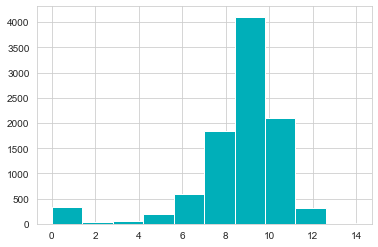

In [19]:
#이상치, 적용 로그 값 제거
TotalLog=np.log(loan['revol.bal']+1)
TotalLog.hist(color='#00afb9')
plt.show()

로그 공식을 사용하면 그래프가 더 '정상'으로 표시됩니다. 우리는 ML 모델을 제작할 때 두 가지 방법을 모두 고려할 것입니다.

'delinq.2yrs'과 'pub.rec'은 값이 4-5개의 값에 걸쳐 분포하는 분포이다. 그들은 요리책처럼 행동하지만 그렇지 않다. 카운트 그림을 사용하면 이러한 분포를 더 잘 나타낼 수 있습니다.

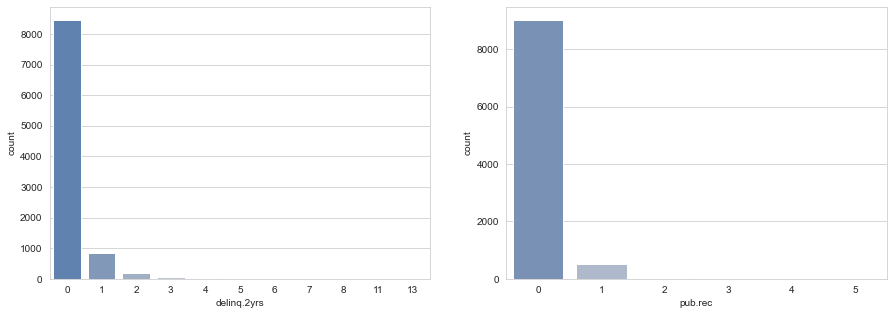

0     8458
1      832
2      192
3       65
4       19
5        6
6        2
7        1
13       1
11       1
8        1
Name: delinq.2yrs, dtype: int64

 0    9019
1     533
2      19
3       5
5       1
4       1
Name: pub.rec, dtype: int64


In [21]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

inte=['delinq.2yrs','pub.rec']

sns.countplot(inte[0],data=loan,ax=ax[0],palette='vlag')
sns.countplot(inte[1],data=loan,ax=ax[1],palette='vlag')

plt.show()

print(loan[inte[0]].value_counts())
print('\n', loan[inte[1]].value_counts())

두 분포 모두 데이터 분석 후 ML 모델을 구축할 때 일부 극단값을 갖는다는 것을 알 수 있습니다.

### 3.3 Booleans

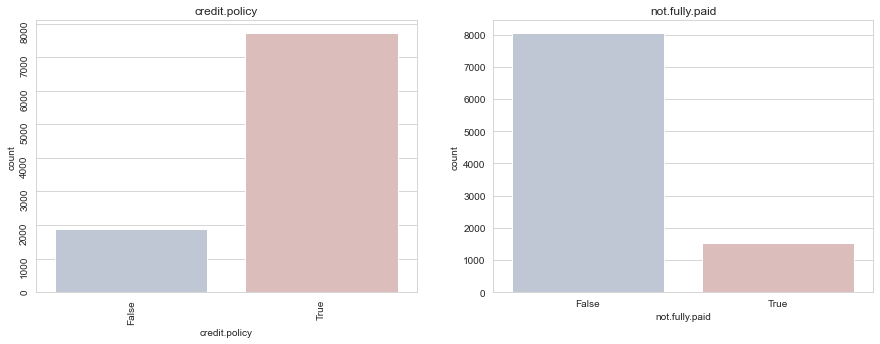

True     7710
False    1868
Name: credit.policy, dtype: int64

 False    8045
True     1533
Name: not.fully.paid, dtype: int64


In [22]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

boole=list(loan.select_dtypes(['bool']).columns)

sns.countplot(boole[0],data=loan,ax=ax[0],palette='vlag')
ax[0].tick_params(labelrotation=90)
ax[0].set_title(boole[0])

sns.countplot(boole[1],data=loan,ax=ax[1],palette='vlag')
ax[0].tick_params(labelrotation=90)
ax[1].set_title(boole[1])

plt.show()

print(loan[boole[0]].value_counts())
print('\n',loan[boole[1]].value_counts())

대부분의 데이터가 거짓이기 때문에 ML 모델에 문제가 될 수 있는 불균형 데이터 사례가 있습니다. 모델을 구축할 때, 우리는 불균형한 데이터를 처리하기 위해 샘플링 기법을 적용할 것입니다.

### 3.4. 기술 분석 결론 및 고려 사항
- 'bal.bal'에는 특이치가 풍부합니다. ML 모형의 경우 특이치를 제거하거나 로그 공식을 적용할 수 있습니다.
- 'delinq.2yrs' 와 'pub.rec'도 특이치가 풍부합니다. 이들은 정수이므로 로그 공식이 현명하지 않을 것 같으므로 ML 모형에 대한 특이치를 빼는 것이 좋습니다.
- not.fully.payed', 대상 변수'가 매우 불균형합니다. 데이터 분석 후와 ML 모델 이전에 샘플 기법을 사용하여 이 사건을 처리하려고 합니다.

## 4. 데이터 분석 및 EDA
목표 변수는 부울이기 때문에 상관 관계가 가장 높은 6개의 산점도를 표시하고 목표 변수와 색조를 취하려고 합니다. 이는 시각적 분석에 더 가깝습니다. 패턴이 발견되지 않으면 모델 기반 피쳐 선택을 적용하여 피쳐 수를 줄이고 모델에 가장 적합한 요소를 분석하겠습니다.

'purpose'은 범주형 변수이므로 막대 그래프로 충분합니다.

"inq.last.6ms", "delinq."2yrs' 및 'pub.rec'은 어떤 일이 발생한 횟수이며, 이러한 사례에 대해서도 막대 그래프가 적용됩니다.

### 4.1 Overlaped Histogram

<AxesSubplot:xlabel='int.rate', ylabel='Count'>

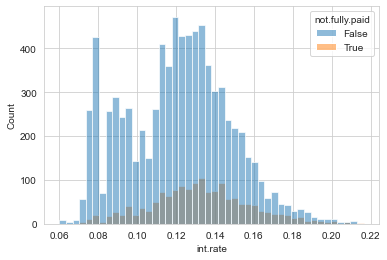

In [24]:
numbers=loan.select_dtypes(['int64','float64']).columns
numbers=numbers[:-3]

sns.histplot(data=loan,x=numbers[0],hue='not.fully.paid')

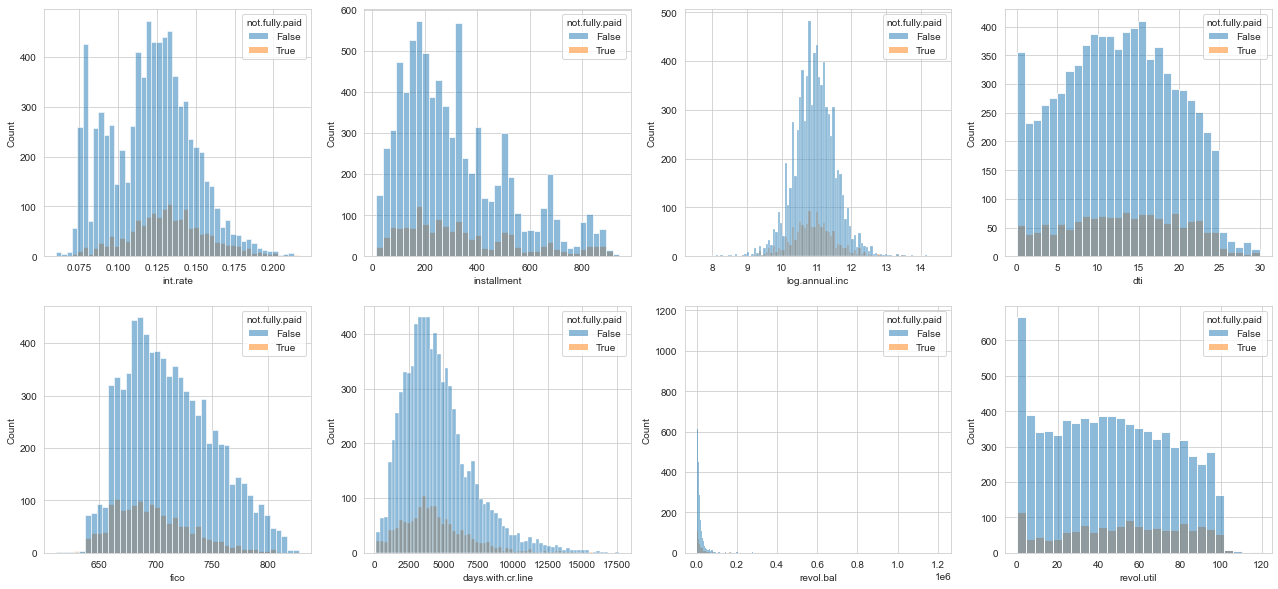

In [28]:
fig,ax=plt.subplots(2,4,figsize=(22,10))
ax=ax.ravel() #다차원의 데이터를 1차원으로 만들어줌

count=0
for i in numbers:
    sns.histplot(data=loan,x=i,hue='not.fully.paid',ax=ax[count])
    count+=1


안타깝게도 두 분포의 모양은 동일하지만 비율이 다르므로 여기서 패턴을 찾기는 어렵습니다. 이러한 변수를 기준으로 목표 변수를 그룹화하고 평균과 표준 편차가 어떻게 다른지 살펴보겠습니다.

In [29]:
loan.groupby('not.fully.paid')[numbers].agg(['mean','std'])

int.rate           installment             log.annual.inc  \
                    mean       std        mean         std           mean   
not.fully.paid                                                              
False           0.120770  0.026692  314.574123  203.398688      10.941091   
True            0.132452  0.025495  342.785114  223.948527      10.885023   

                                dti                  fico             \
                     std       mean       std        mean        std   
not.fully.paid                                                         
False           0.604045  12.494413  6.855020  713.326911  38.223723   
True            0.666718  13.195838  7.006769  697.828441  33.756808   

               days.with.cr.line                  revol.bal                \
                            mean          std          mean           std   
not.fully.paid                                                              
False                4592.632624  2508.035500  16122.724425  29637.645740   
True                 4393.541259  2431.785491  21066.293542  49905.689359   

               revol.util             
                     mean        std  
not.fully.paid                        
False           45.759608  28.891285  
True            52.255075  29.057906

역시 그들은 큰 차이가 없다. 여기서 얻을 수 있는 유일한 결론은 목표 변수가 각 피쳐에 거의 동등하게 분포되어 있다는 것입니다. 따라서 우리 모델과 관련된 패턴은 없습니다.

### 4.2 Barplots

['inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'credit.policy']


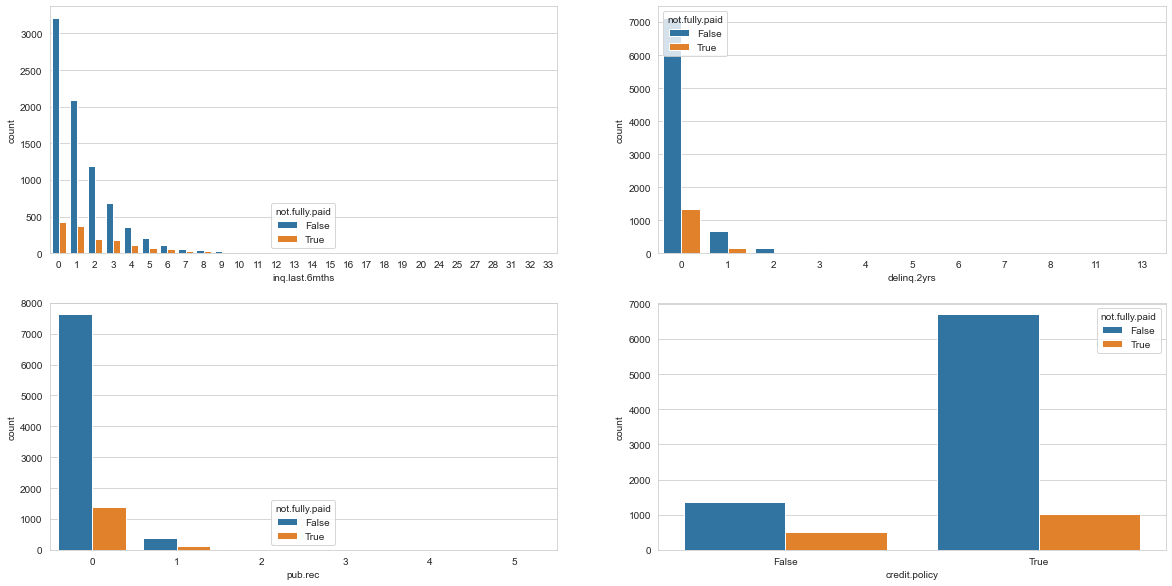

In [33]:
# Features to graph
numbers = loan.select_dtypes(['int64', 'float64']).columns
numbers = list(numbers[-3:])
numbers.append("credit.policy")
print(numbers)

# Viz
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax=ax.ravel()

count=0
for i in numbers:
    sns.countplot(x=i, data=loan, hue='not.fully.paid', ax=ax[count])
    count+=1

plt.show()

관련 통찰력 또한 없습니다. 모델 기반 피쳐 선택 항목을 적용하여 알고리즘이 눈에 보이지 않는 것을 표시하도록 하겠습니다.

## 5. 모델 기반 피쳐 선택.
모델 기반 피쳐 선택은 감독된 기계 학습 모델을 사용하여 각 피쳐의 중요성을 판단하고 가장 중요한 기능만 유지합니다. 이 경우에는 기능을 정규화할 필요 없이 대개 좋은 결과를 얻기 때문에 랜덤 포리스트 분류기를 사용하려고 합니다. 어디 한번 봅시다

In [36]:
# M1 values
numbers=loan.select_dtypes(['int64','float64','bool']).columns

X=loan[numbers].iloc[:,:-1].values
y=loan.iloc[:,-1].values.reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [37]:
for i in range(1,13):
    select=RFE(RandomForestClassifier(n_estimators=100,random_state=42),n_features_to_select=i)
    
    select.fit(X_train,y_train)
    
    mask=select.get_support()
    
    X_train_rfe=select.transform(X_train)
    X_test_rfe=select.transform(X_test)
    
    score=RandomForestClassifier().fit(X_train_rfe,y_train).score(X_test_rfe,y_test)
    
    print('Test score : {:.3f}'.format(score), ' number of features : {}'.format(i))

Test score : 0.741  number of features : 1
Test score : 0.816  number of features : 2
Test score : 0.833  number of features : 3
Test score : 0.835  number of features : 4
Test score : 0.838  number of features : 5
Test score : 0.840  number of features : 6
Test score : 0.839  number of features : 7
Test score : 0.838  number of features : 8
Test score : 0.841  number of features : 9
Test score : 0.837  number of features : 10
Test score : 0.836  number of features : 11
Test score : 0.837  number of features : 12


시험 점수 차이가 별로 없어요. 나는 5가지 기능을 선택해서 알고리즘이 무엇을 선택하는지 볼 것이다.

In [38]:
select=RFE(RandomForestClassifier(n_estimators=100,random_state=42),n_features_to_select=5)

select.fit(X_train,y_train)

mask=select.get_support()#선택한 특성을 bool값으로 표시해 어떤 특성이 선택되었는지 확인가능
X_train_rfe=select.transform(X_train)
X_test_rfe=select.transform(X_test)

score=RandomForestClassifier().fit(X_train_rfe,y_train).score(X_test_rfe,y_test)
print('Test score : {:.3f}'.format(score), ' number of features : {}'.format(5))

features=pd.DataFrame({'features':list(loan[numbers].iloc[:,:-1].columns),'select':list(mask)})
display(features.T)
features=list(features[features['select']==True]['features'])
print('The selected features are : " "\n')
display(features)

Test score : 0.840  number of features : 5


,0,1,2,3,4,5,6,7,8,9,10,11
features,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
select,False,False,True,False,True,False,True,True,True,False,False,False


The selected features are : " "



['installment', 'dti', 'days.with.cr.line', 'revol.bal', 'revol.util']

작업 기능이 있으므로 대상 변수를 추가하지 마십시오.'full.payed'를 선택하고 의사결정 트리 적용을 진행합니다. 그럼 계속 채굴해서 모형을 그래프로 표시해서 패턴을 찾을 수 있는지 봐야겠네요.

In [39]:
features.append('not.fully.paid')

print('Working dataset', '\n')
loan[features]

Working dataset 



,installment,dti,days.with.cr.line,revol.bal,revol.util,not.fully.paid
0,829.10,19.48,5639.958333,28854,52.1,False
1,228.22,14.29,2760.000000,33623,76.7,False
2,366.86,11.63,4710.000000,3511,25.6,False
3,162.34,8.10,2699.958333,33667,73.2,False
4,102.92,14.97,4066.000000,4740,39.5,False
...,...,...,...,...,...,...
9573,344.76,10.39,10474.000000,215372,82.1,True
9574,257.70,0.21,4380.000000,184,1.1,True
9575,97.81,13.09,3450.041667,10036,82.9,True
9576,351.58,19.18,1800.000000,0,3.2,True


## 6. Decision Tree

### 6.1 Resampling
섹션 3.4에서 데이터의 불균형이 심하다는 것을 알 수 있으므로 데이터셋을 표준화하기 전에 다시 샘플링 알고리즘을 적용해 보겠습니다. 이 경우에는 랜덤 오버샘플링 알고리즘을 적용하여 소수 계층에서 합성 데이터를 만들 것입니다.

In [41]:
loan_ros=loan[features]
print('Data before over-sampling')
print(loan_ros['not.fully.paid'].value_counts(),'\n')

Data before over-sampling
False    8045
True     1533
Name: not.fully.paid, dtype: int64 



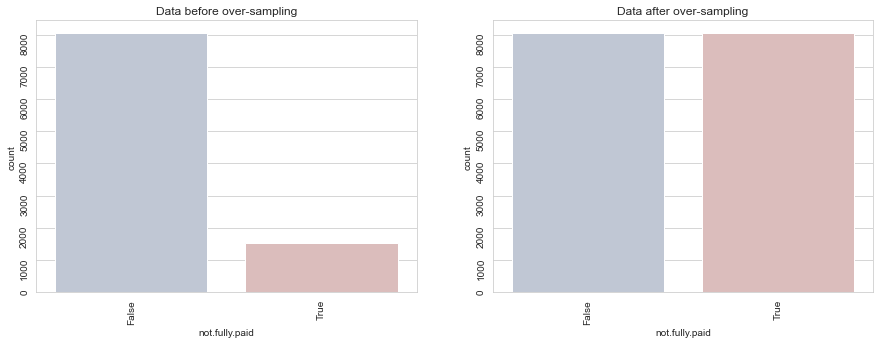

Data before over-sampling
False    8045
True     1533
Name: not.fully.paid, dtype: int64 

Data after over-sampling
True     8045
False    8045
Name: not.fully.paid, dtype: int64


In [42]:
#over sampling
lona_ros=loan[features]
X=loan_ros.iloc[:,:-1]
y=loan_ros.iloc[:,-1]

ros=RandomOverSampler(random_state=42)
x_ros,y_ros=ros.fit_resample(X,y)

loan_ros=x_ros
loan_ros['not.fully.paid']=y_ros

#visualiazing samples
fig,ax=plt.subplots(1,2,figsize=(15,5))

sns.countplot('not.fully.paid',data=loan,ax=ax[0],palette='vlag')
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Data before over-sampling')

sns.countplot('not.fully.paid',data=loan_ros,ax=ax[1],palette='vlag')
ax[1].tick_params(labelrotation=90)
ax[1].set_title('Data after over-sampling')

plt.show()

print('Data before over-sampling')
print(loan['not.fully.paid'].value_counts(),'\n')

print('Data after over-sampling')
print(loan_ros['not.fully.paid'].value_counts())

균형 잡힌 데이터만 있으면 모델을 구축할 수 있습니다. 먼저 새로 균형 잡힌 데이터로 분포를 살펴보겠습니다.

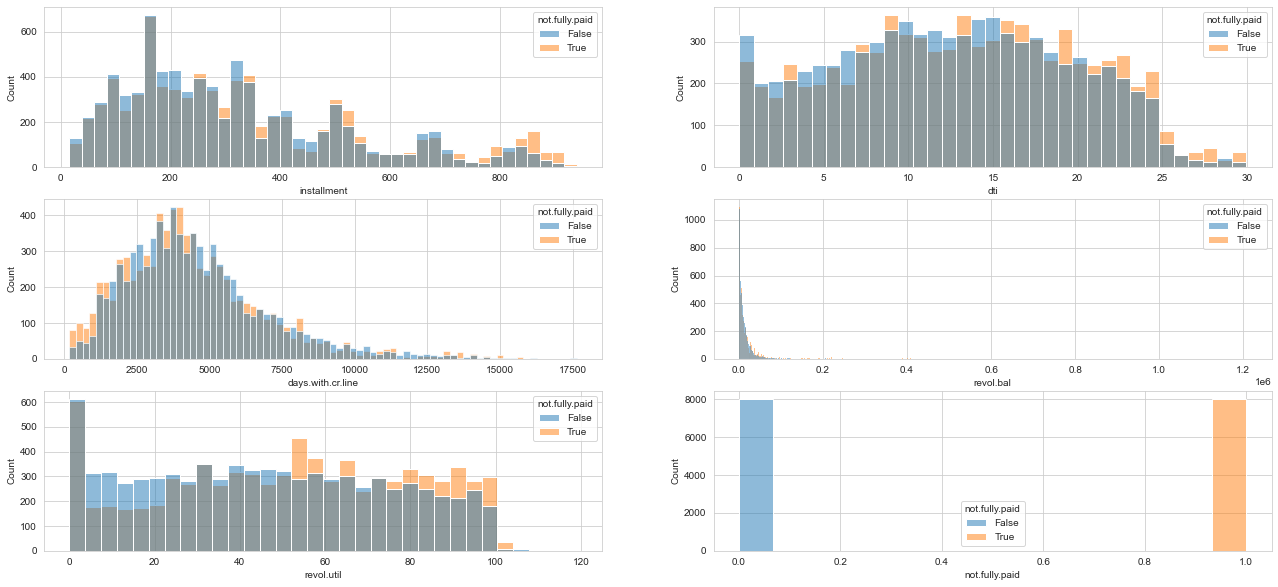

In [43]:
fig,ax=plt.subplots(3,2,figsize=(22,10))
ax=ax.ravel()

count=0
for i in loan_ros.keys():
    sns.histplot(data=loan_ros,x=i,hue='not.fully.paid',ax=ax[count])
    count+=1

아직 패턴이 없습니다. 모델이 말해주는 것을 봅시다.

### 6.2 Tree model

Accuracy on training set : 0.757
Accuracy on test set : 0.702 



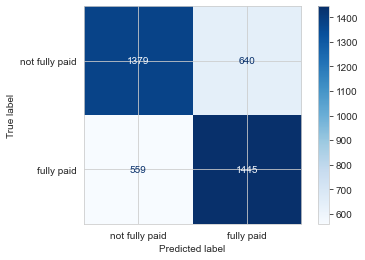

[[1379  640]
 [ 559 1445]] 

Feature importances
[0.22807276 0.18140467 0.2387935  0.20038809 0.15134099]


In [46]:
#Selecting training values
loan_model=loan_ros
X=loan_model.iloc[:,:-1].values
y=loan_model.iloc[:,-1].values

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

#Building model

tree=DecisionTreeClassifier(max_depth=12,random_state=0)
tree.fit(X_train,y_train)

print('Accuracy on training set : {:.3f}'.format(tree.score(X_train,y_train)))
print('Accuracy on test set : {:.3f}'.format(tree.score(X_test,y_test)),'\n')

#Confusion matrix
disp=plot_confusion_matrix(tree,X_test,y_test,cmap=plt.cm.Blues, display_labels=['not fully paid','fully paid'])
plt.show()

print(disp.confusion_matrix,'\n')

print('Feature importances')
print(tree.feature_importances_)

우리는 허용 가능한 점수와 confusion_matrix를 달성했습니다. 피쳐 중요도는 데이터에서 패턴을 찾기 어려운 이유를 보여줍니다. 모든 피쳐의 중요도는 유사합니다. 즉, 모델이 모든 피쳐의 미세 튜닝 조합입니다. 이러한 기능을 사용할 경우 클라이언트 프로파일을 작성하기가 어렵습니다. 그러나 은행 운영자가 시스템에 데이터를 입력할 때 알고리즘은 에이전트에 고객이 지불을 완전히 할 수 있는지 여부를 알려줍니다.

## 7. 결론
- 어떤 패턴도 찾을 수 없었어요 목표 변수가 모든 변수에 균등하게 분포된 데이터입니다. 마치 가상 데이터 집합처럼 보이는군
- 그럼에도 불구하고 알고리즘은 적절하고 더 실제적인 테스트 점수(불균형 데이터로 작업하면 더 나은 결과를 얻을 수 있지만 실제 결과는 아님)에 도달할 수 있었고, 대상 변수의 두 결과를 혼동 행렬에 분류할 수 있었다.
- 우리는 고객 프로파일 작성의 목적을 달성하지 못했지만, 에이전트가 이 알고리즘을 사용하여 고객이 비용을 지불할 가능성이 있는지 여부를 확인할 수 있어 의사 결정 과정이 쉬워졌습니다.